In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

# Custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    y_pred_clipped = tf.clip_by_value(y_pred, 1e-9, 1.0)  # Clip values to avoid log(0)
    entropy_reg = -tf.reduce_mean(y_pred_clipped * tf.math.log(y_pred_clipped))
    lambda_entropy = 0.01
    return mse + lambda_entropy * entropy_reg

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data1(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        print('samples_fft.shape:', samples_fft.shape)

        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)

#         # Normalize the real and imaginary parts
#         real_parts = (real_parts - np.mean(real_parts, axis=1, keepdims=True)) / np.std(real_parts, axis=1, keepdims=True)
#         imag_parts = (imag_parts - np.mean(imag_parts, axis=1, keepdims=True)) / np.std(imag_parts, axis=1, keepdims=True)
        
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)
            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue

            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data1(samples)
                #X_chunk = self.process_data2(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []
#------------------------------------------------------------------------------------------------------
# Minimum Entropy Coupling (MEC) Functions
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))
    #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)
    def body(r, M, J):
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])
        # ensure tensors have same datatype
        a_i = tf.cast(a_i, dtype=tf.int32)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)
        #prepare indices for scatter update
        indices = tf.stack([indices_range, a_i], axis=1)
        #now update
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        J = J + J_updates
        return r_updated, M, J

    def condition(r, M, J):
        return r > 0
    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])
    return J
# def simplified_mec_kocaoglu_np(p, q):
#     # Ensure p and q are normalized to the same sum
#     p_normalized = tf.cast(p, tf.float64) / tf.reduce_sum(p)
#     q_normalized = tf.cast(q, tf.float64) / tf.reduce_sum(q)
#     # Compute a simple average of the two distributions
#     averaged_distribution = (p_normalized + q_normalized) / 2
#     #simplified_feature = tf.cast(averaged_median > 0.5, tf.float64)
#     #transformed_distribution = tf.fill(tf.shape(p_normalized), simplified_feature)
#     fixed_threshold = 0.5  # Example fixed parameter
#     transformed_distribution = tf.where(averaged_distribution > fixed_threshold,
#                                         averaged_distribution,
#                                         tf.zeros_like(averaged_distribution))
#     return transformed_distribution

def apply_mec_to_data(data, num_bins=25, latent_dim=25):
    print('data.shape in apply mec:', data.shape)
    """
    Apply the MEC transformation to each sample in the data using tf.map_fn.
    """
    def process_sample(sample):
        min_val = tf.reduce_min(sample)
        max_val = tf.reduce_max(sample)
        sample_distribution = tf.histogram_fixed_width(sample, [min_val, max_val], nbins=num_bins)
        sample_distribution = tf.cast(sample_distribution, tf.float64)
        sum_distribution = tf.cast(tf.reduce_sum(sample_distribution), tf.float64)
        sample_distribution /= sum_distribution

        mec_transformed = mec_kocaoglu_np(sample_distribution, sample_distribution)

        # Flatten the 2D to 1D
        if len(mec_transformed.shape) > 1:
            transformed_sample = tf.reshape(mec_transformed, [-1])

        # slice/pad to match the latent_dim
        if transformed_sample.shape[0] > latent_dim:
            transformed_sample = transformed_sample[:latent_dim]
        elif transformed_sample.shape[0] < latent_dim:
            padding = tf.zeros(latent_dim - transformed_sample.shape[0], dtype=tf.float64)
            transformed_sample = tf.concat([transformed_sample, padding], axis=0)

        return tf.reshape(transformed_sample, (latent_dim,))
    # apply function to each sample in the batch
    transformed_batch = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

    return transformed_batch
# def apply_mec_to_data_simple(data, latent_dim=25):
#     def process_sample(sample):
#         print("Original sample:", sample)  # Diagnostic print        
#         sample = tf.cast(sample, tf.float64)
#         sample_normalized = sample / tf.reduce_sum(sample, keepdims=True)
#         print("Normalized sample:", sample_normalized)        
#         # Apply MEC transformation
#         #mec_transformed = mec_kocaoglu_np(sample_normalized, sample_normalized)
#         mec_transformed = simplified_mec_kocaoglu_np(sample_normalized, sample_normalized)       
#         # Flatten the MEC-transformed tensor to 1D for simplicity
#         mec_transformed_flat = tf.reshape(mec_transformed, [-1])
#         print("Flattened MEC-transformed tensor:", mec_transformed_flat)
        
#         # Calculate padding size
#         padding_size = tf.maximum(tf.cast(0, tf.int64), latent_dim - tf.cast(tf.size(mec_transformed_flat), tf.int64))
#         padded_mec_transformed = tf.pad(mec_transformed_flat, paddings=[[0, padding_size]], constant_values=0.0)
#         print("Padded MEC-transformed tensor shape:", padded_mec_transformed.shape)        
#         # Ensure the tensor matches exactly the latent_dim
#         final_transformed = padded_mec_transformed[:latent_dim]
#         print("Final transformed tensor shape:", final_transformed.shape)
#         return final_transformed
#     # Apply the process to each sample and return the transformed data
#     transformed_data = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)
#     print("Transformed data shape:", transformed_data.shape)
#     return transformed_data

def process_latent_variables(z):
    z_transformed = apply_mec_to_data(z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed
#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)
# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim,
                 epsilon_std=0.1, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        self._build()
        #self._build2()

    def _sampling3(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        #tf.print('z_mean:', z_mean)
        z_mean_transformed = process_latent_variables(z_mean)
        #tf.print('z_mean_transformed:', z_mean_transformed)
        epsilon_std = 0.1  # Use a fixed small std deviation to reduce variability
        #epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=K.shape(z_mean_transformed), mean=0., stddev=epsilon_std)
        #epsilon = process_latent_variables(epsilon)
        #tf.print('epsilon_value:', epsilon)
        epsilon = tf.cast(epsilon, 'float64')  # Cast epsilon to float64
        
        #a = z_mean_transformed + epsilon
        #tf.print('a:', a)
        #return a
        return z_mean_transformed
        #return z_mean + epsilon
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    
#     def _sampling4(self, args):
#         z_mean, z_log_var = args
#         z_mean_transformed = process_latent_variables(z_mean)
#         z_log_var_transformed = process_latent_variables(z_log_var)
#         batch = K.shape(z_mean_transformed)[0]
#         dim = K.int_shape(z_mean_transformed)[1]
#         z_mean_transformed = tf.cast(z_mean_transformed, tf.float32)
#         z_log_var_transformed = tf.cast(z_log_var_transformed, tf.float32)

#         epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
#         output = z_mean_transformed + K.exp(0.5 * z_log_var_transformed) * epsilon
#         return output
        
    def _build(self):
        # Encoder
        #model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 8), 
                       #return_sequences=True)
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        #x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=True))(inputs)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(inputs)
        #x = Dropout(self.dropout_rate)(x)
        #self_attention = SelfAttentionLayer(num_heads=2, key_dim=self.original_dim)  # Adjust num_heads and key_dim as needed
        #x = self_attention(x)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=False)(x)
        #x = Dropout(self.dropout_rate)(x)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        #z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        z = Lambda(self._sampling3, output_shape=(self.latent_dim,))([z_mean, z_mean])
        # Initiate Encoder
        # If want to skip the sampling part[
        #latent_repr = Dense(self.latent_dim, name='latent_repr')(x)
        #self.encoder = Model(inputs, latent_repr, name='encoder')
        #]
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')        
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        final_activation = 'sigmoid' #'linear' if data is not normalized
        #outputs = TimeDistributed(Dense(self.original_dim, activation=final_activation))(x)
        outputs = TimeDistributed(Dense(self.feature_dim))(x)
        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def simplified_vae_loss(self, x, x_decoded_mean, z_mean):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        mean_loss = tf.reduce_mean(tf.square(z_mean))
        total_loss = mse + mean_loss
        return K.mean(total_loss)
    
    def compile(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)

    def compile2(self, learning_rate=0.0005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a wrapper function for the custom loss
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.custom_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_custom(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, _, _ = self.encoder(x)
            return self.simplified_vae_loss(x, x_decoded_mean, z_mean)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_simple_autoencoder(self, learning_rate=0.005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        
        # Simple reconstruction loss
        self.vae.compile(optimizer=optimizer, loss='mse')

# Instantiate and Compile the VAE
sequence_length = 10
feature_dim = 2
original_dim = 50
intermediate_dim = 50
latent_dim = 25

vae_model = VAE(sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
#vae_model.compile2(learning_rate=0.005)
vae_model.compile_simple_autoencoder(learning_rate=0.005)
#vae_model.compile_custom(learning_rate=0.005)

# Model Training
batch_size = 40
max_train_samples = 1000000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 1000000  # Maximum samples to read (or None to read all)
max_test_samples = 1000000

pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# Example file patterns
#pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
#mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# Data Generator Instances
# train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
#                                       max_train_samples, for_training=True)
# combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
#                                          max_test_samples, for_training=False)
train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)
combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)

num_epochs = 4  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        #loss = model.train_on_batch(X_chunk, Y_chunk)
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()

num_predictions = 100  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")


reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        #X_chunk_pred = model.predict(X_chunk_test)
        X_chunk_pred = vae_model.vae.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)        
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")


reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

print('max_error_per_sequence.shape:', max_error_per_sequence.shape)

threshold1 = np.percentile(max_error_per_sequence, 98)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)

#is_intrusion_detected2 = error_per_sequence > threshold1

num_total_sequences = len(max_error_per_sequence)
num_total_sequences2 = num_predictions * batch_size - num_predictions
print('num_total_sequences:', num_total_sequences)
print('num_total_sequences2:', num_total_sequences2)

#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = max_error_per_sequence.flatten()
#flat_error_per_sequence2 = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)

#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")




2024-04-26 12:24:55.042265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 12:24:55.043462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 12:24:55.067365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 12:24:55.067859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 12:24:55.449135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

data.shape in apply mec: (None, 25)
Instructions for updating:
Use fn_output_signature instead
data.shape in apply mec: (None, 25)
File extension detected: 
File extension detected: 
Epoch 1/4
File extension detected: 
data.shape in apply mec: (390, 25)
data.shape in apply mec: (390, 25)
Step 1/2500, Loss: 0.9991889595985413
Step 101/2500, Loss: 1.007832646369934
Step 201/2500, Loss: 1.0148932933807373
Step 301/2500, Loss: 0.5967511534690857
Step 401/2500, Loss: 0.9500006437301636
Step 501/2500, Loss: 0.9492059350013733
Step 601/2500, Loss: 1.1874960660934448
Step 701/2500, Loss: 0.955553412437439
Step 801/2500, Loss: 0.9658957719802856
Step 901/2500, Loss: 1.0037181377410889
Step 1001/2500, Loss: 0.9673647880554199
Step 1101/2500, Loss: 1.0597941875457764
Step 1201/2500, Loss: 0.9968558549880981
Step 1301/2500, Loss: 0.9294713139533997
Step 1401/2500, Loss: 1.1255297660827637
Step 1501/2500, Loss: 0.9638518691062927
Step 1601/2500, Loss: 0.9440110921859741
Step 1701/2500, Loss: 0.9334

13/13 [==============================] - 0s 8ms/step
prediction number: 36
13/13 [==============================] - 0s 8ms/step
prediction number: 37
13/13 [==============================] - 0s 8ms/step
prediction number: 38
13/13 [==============================] - 0s 8ms/step
prediction number: 39
13/13 [==============================] - 0s 8ms/step
prediction number: 40
13/13 [==============================] - 0s 8ms/step
prediction number: 41
13/13 [==============================] - 0s 8ms/step
prediction number: 42
13/13 [==============================] - 0s 8ms/step
prediction number: 43
13/13 [==============================] - 0s 8ms/step
prediction number: 44
13/13 [==============================] - 0s 8ms/step
prediction number: 45
13/13 [==============================] - 0s 8ms/step
prediction number: 46
13/13 [==============================] - 0s 8ms/step
prediction number: 47
13/13 [==============================] - 0s 9ms/step
prediction number: 48
13/13 [==================

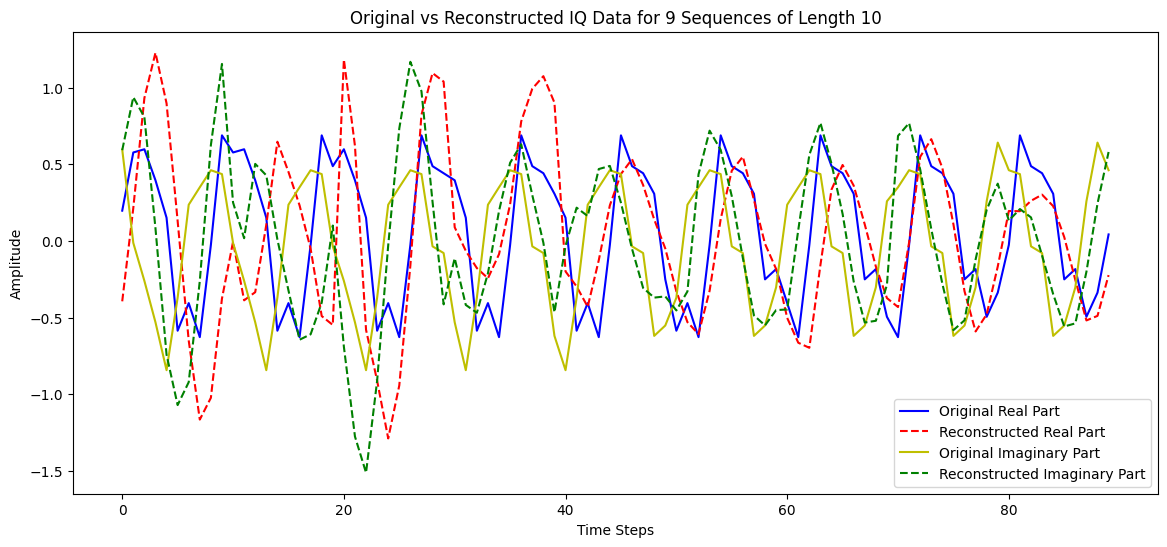

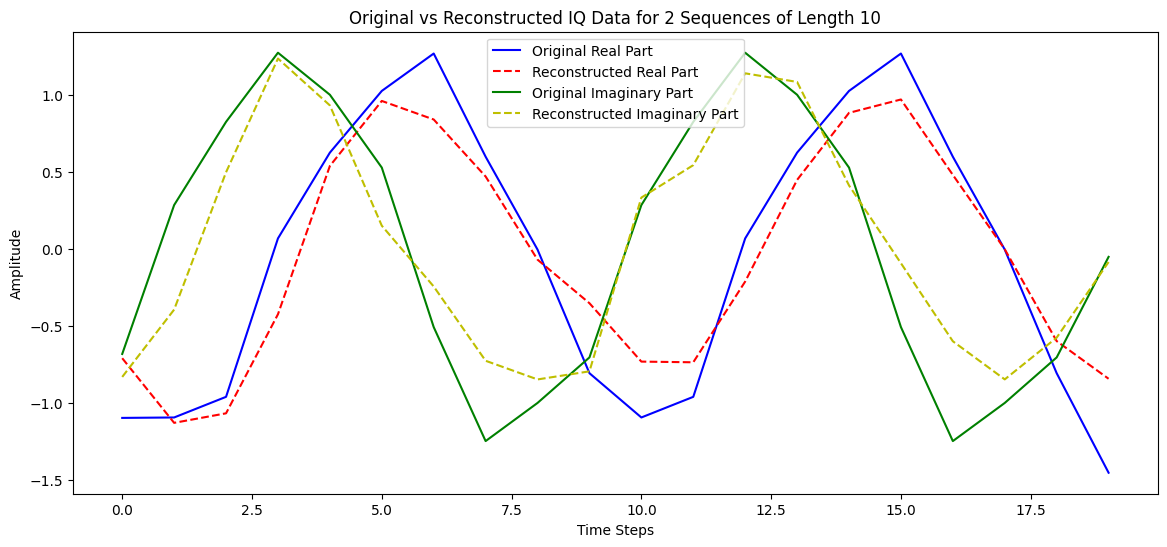

In [16]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

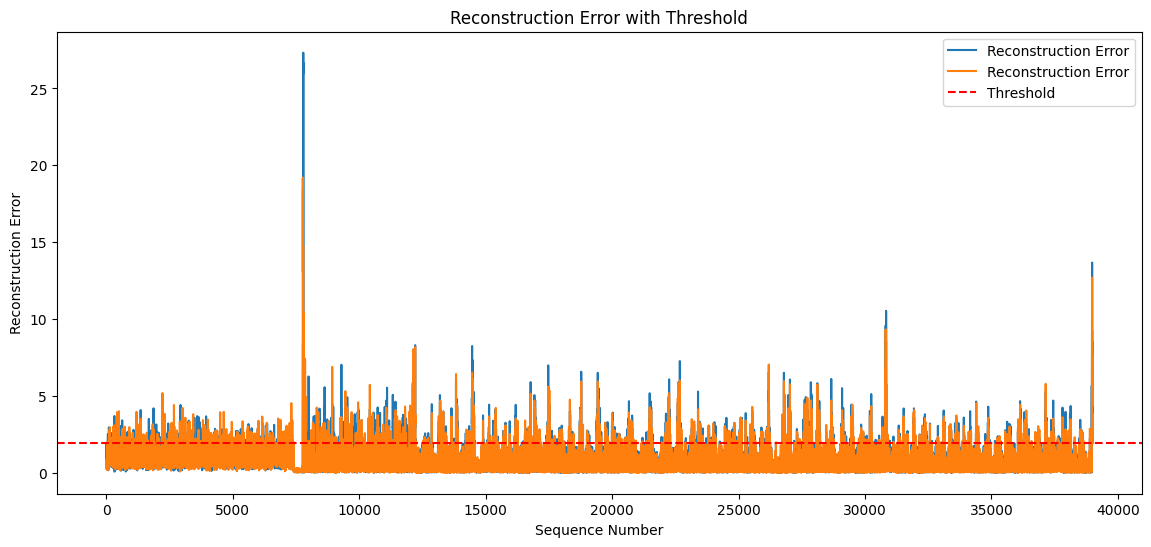

In [3]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

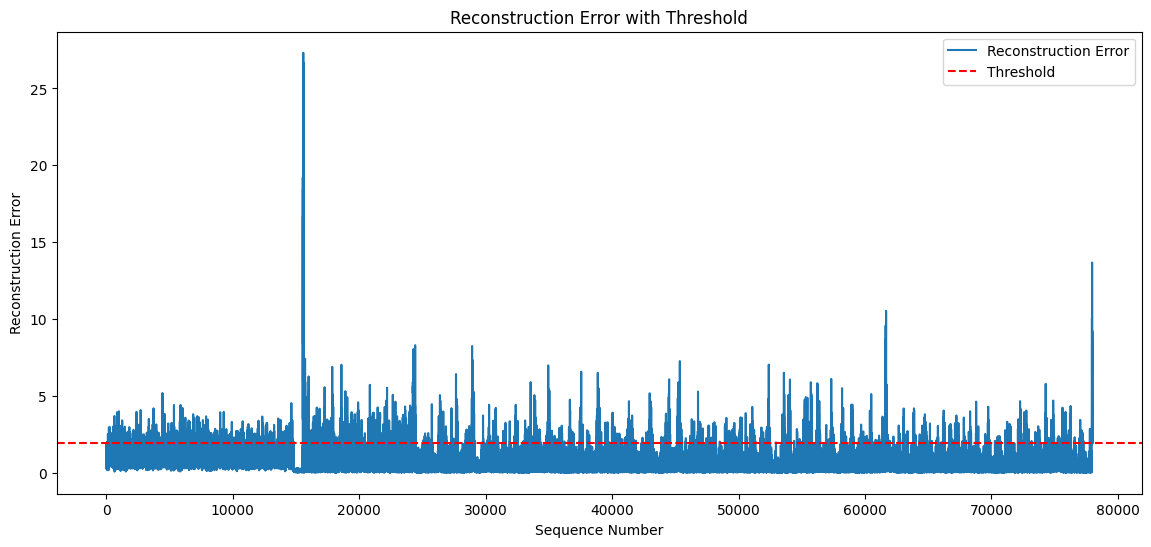

In [4]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


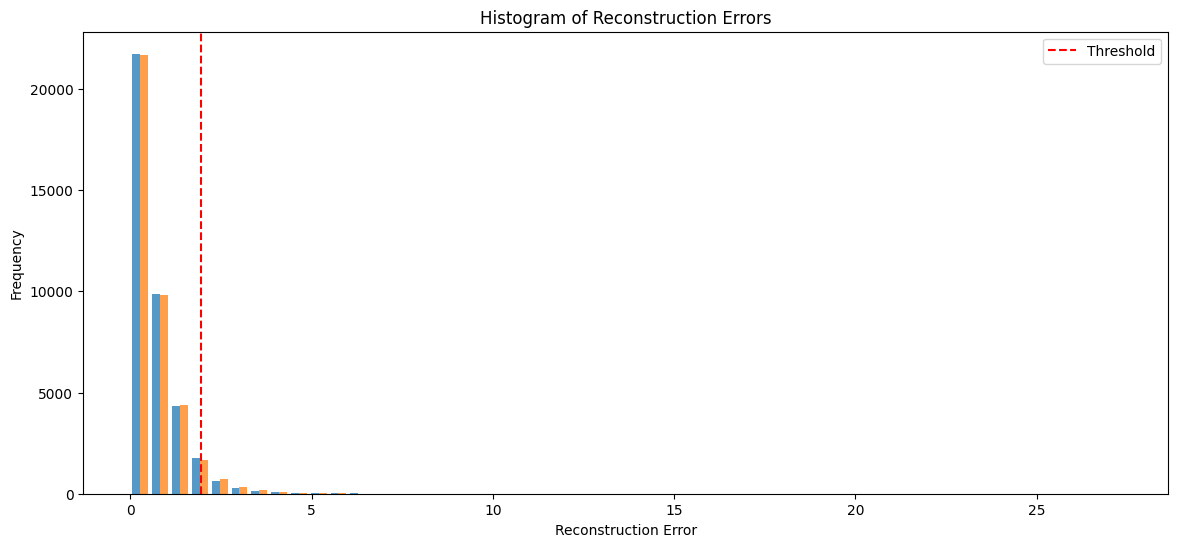

In [5]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


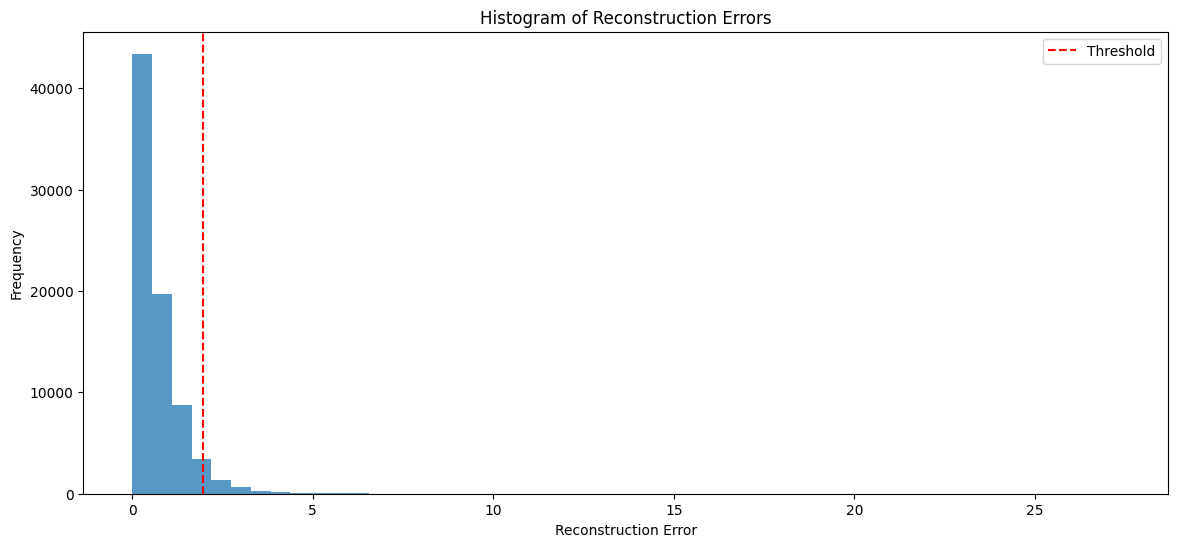

In [6]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

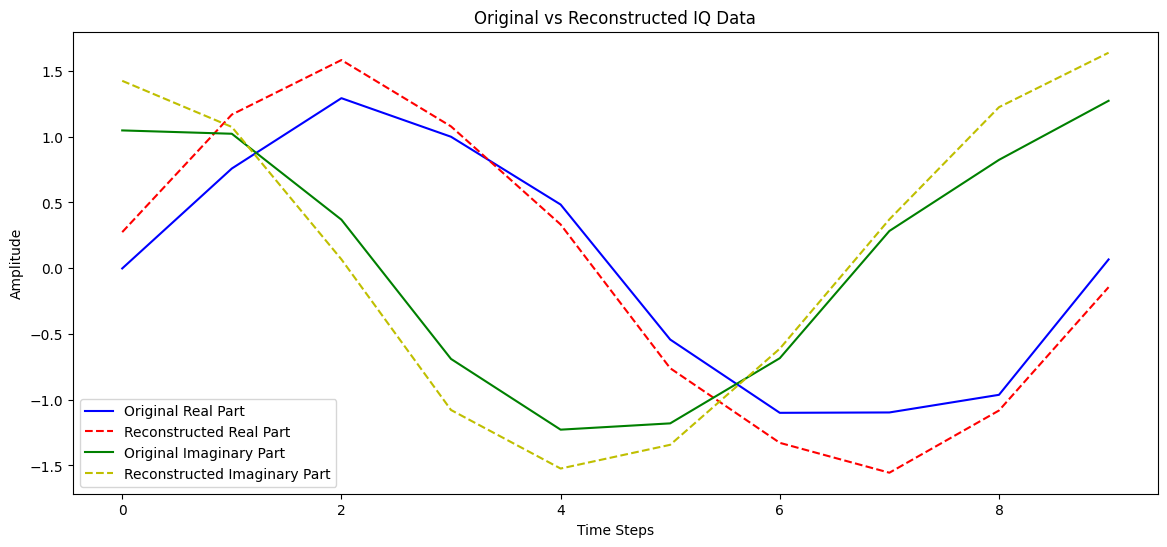

In [7]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()


Shape of avg_real: (390,)
Shape of avg_imag: (390,)
Shape of last_errors: 390


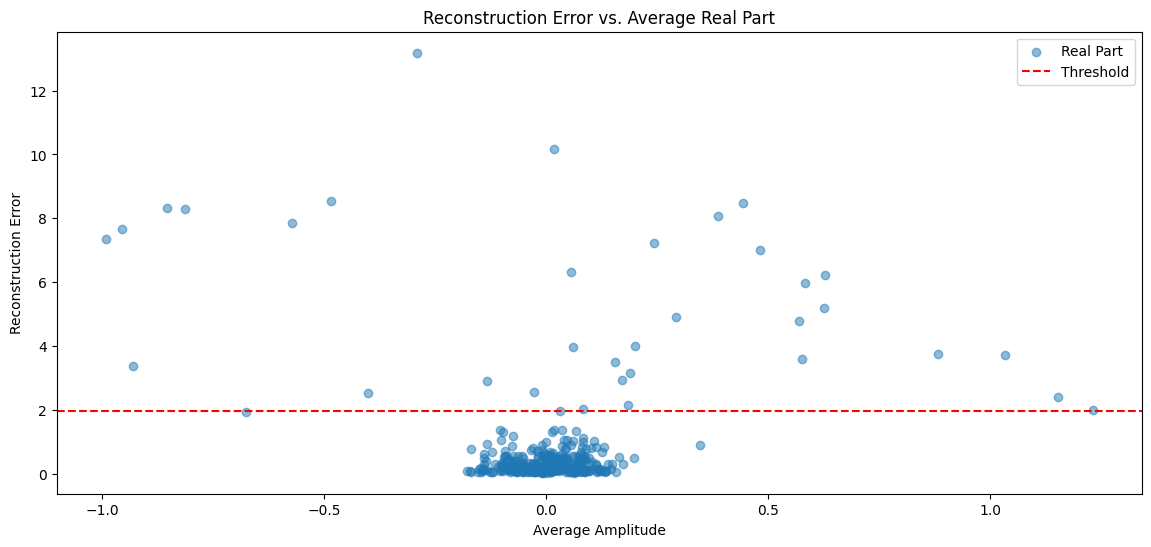

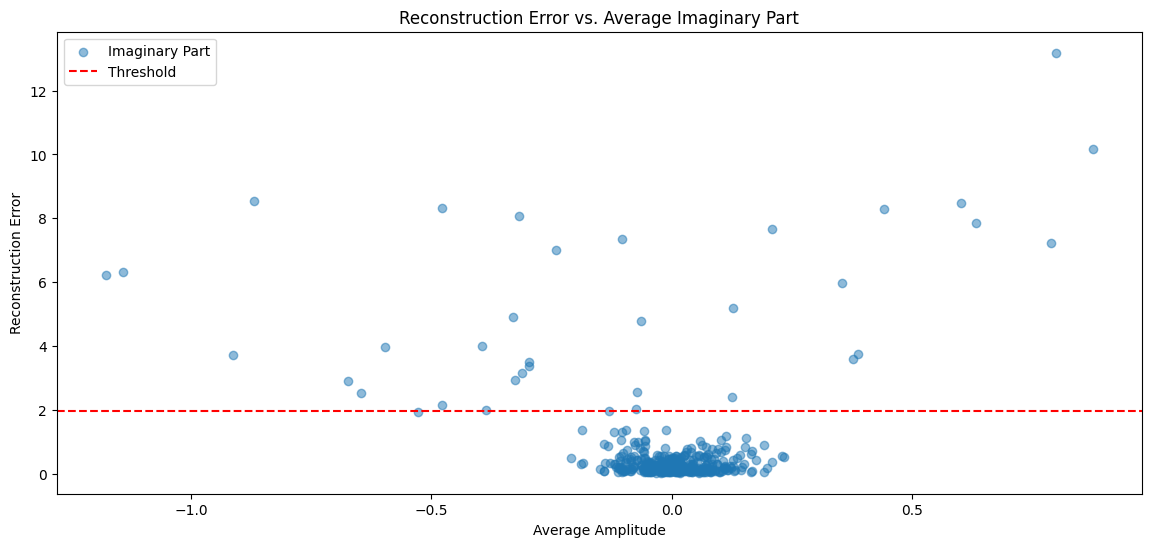

In [8]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

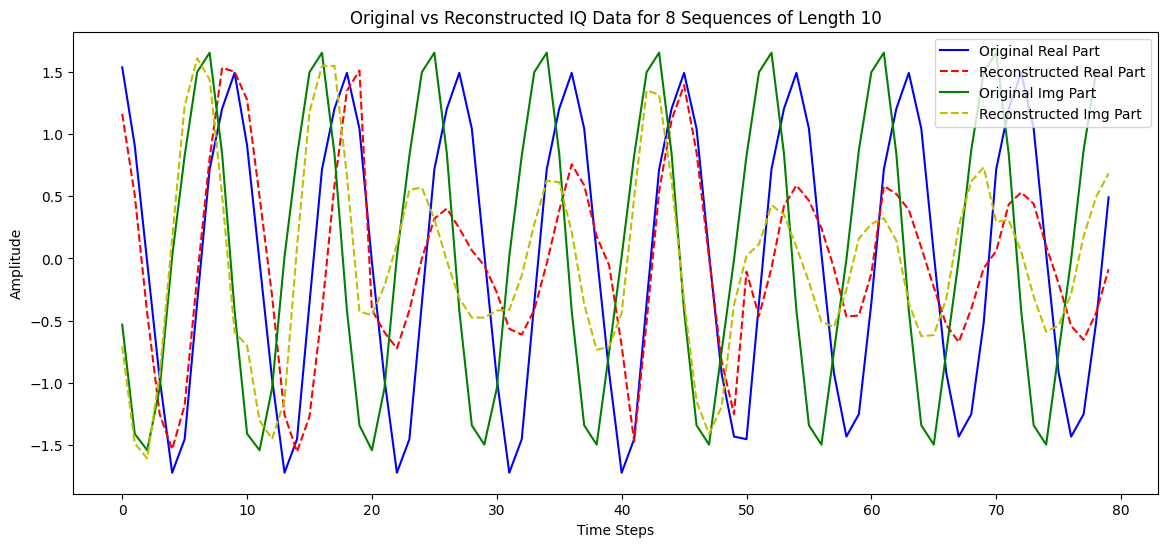

In [9]:
# # Define the number of sequences to plot together
n = 8  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Img Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Img Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

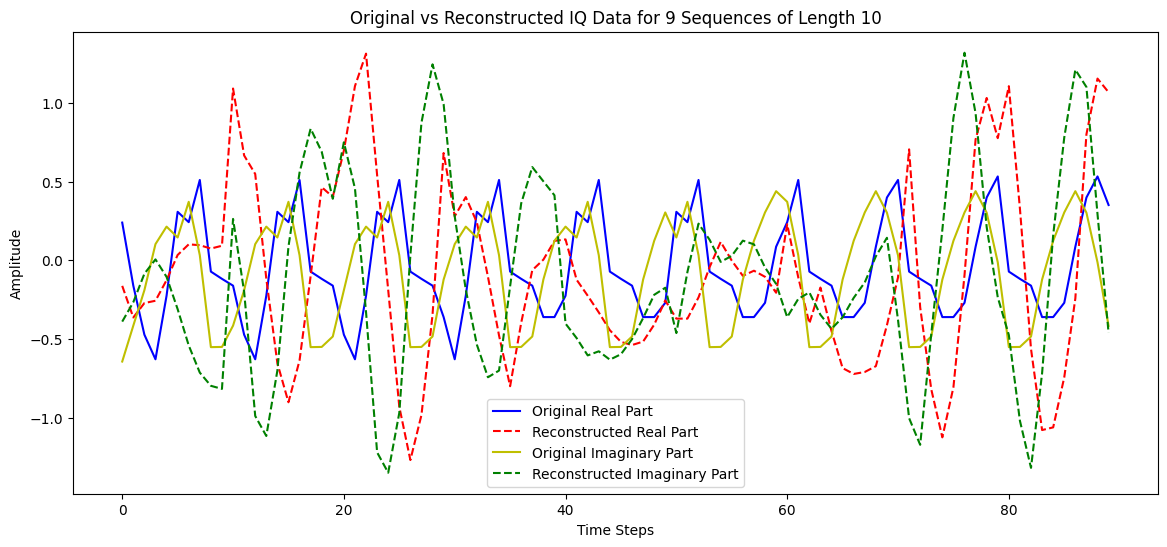

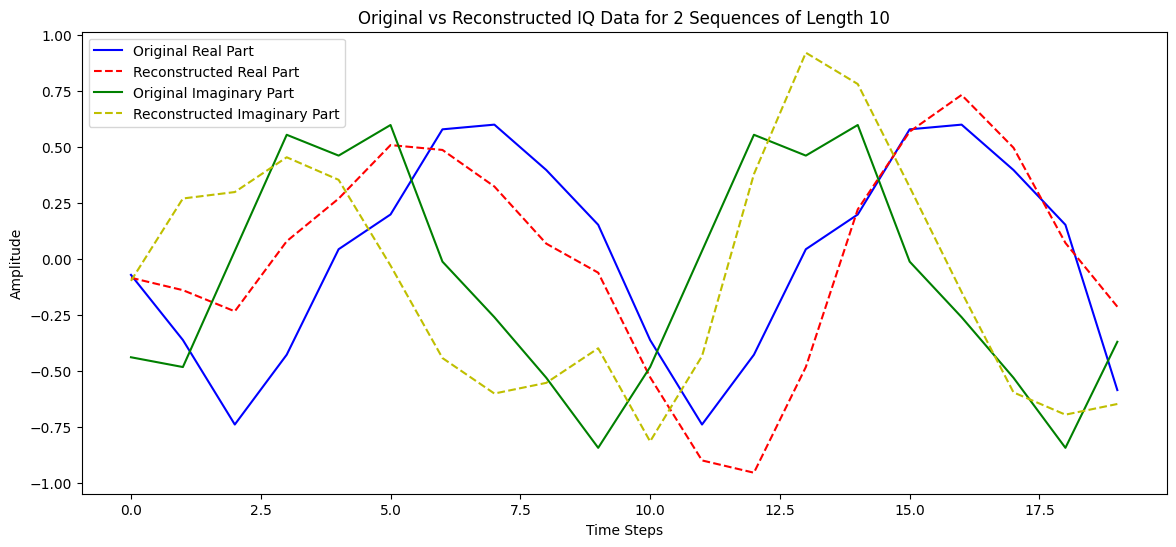

In [10]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

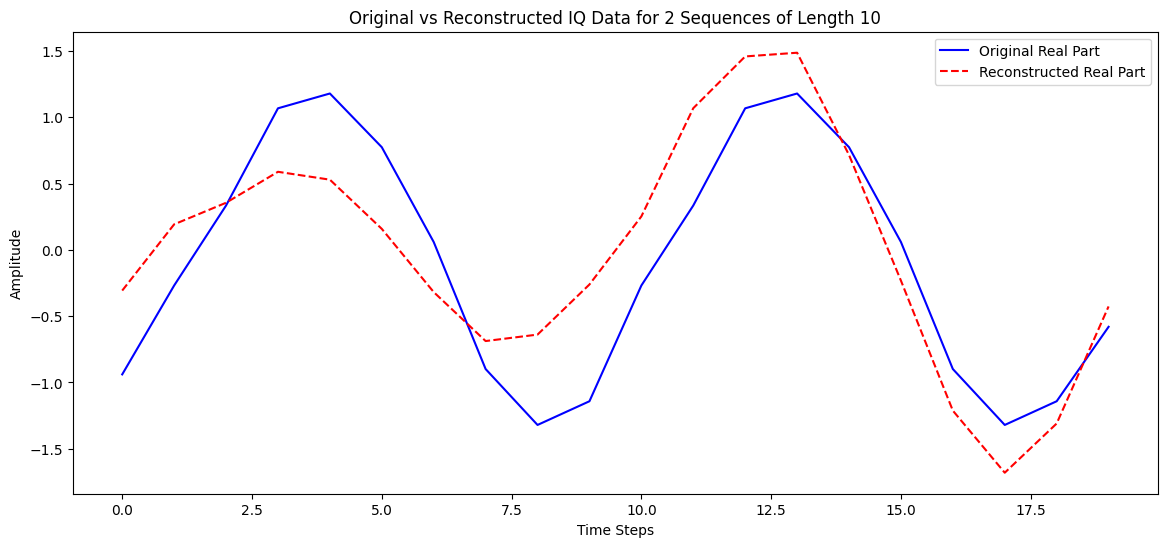

In [11]:
# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')

plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

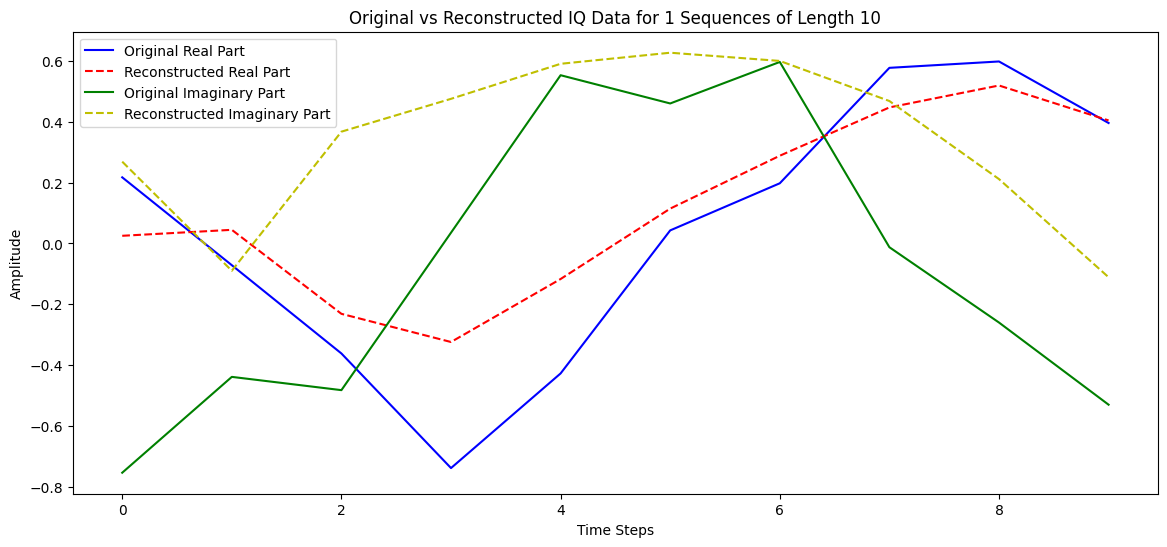

In [12]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

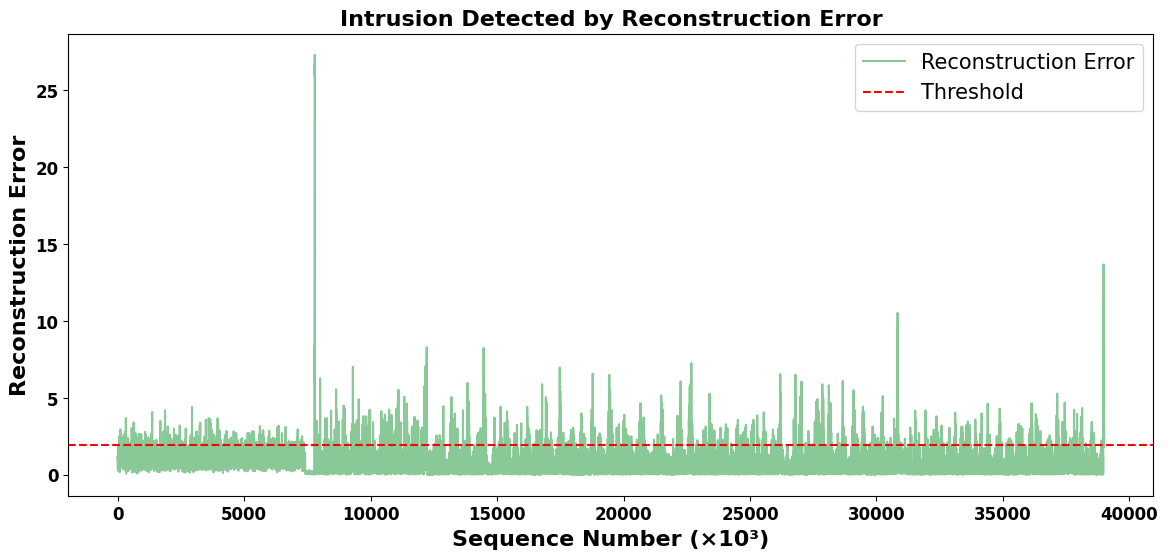

In [13]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

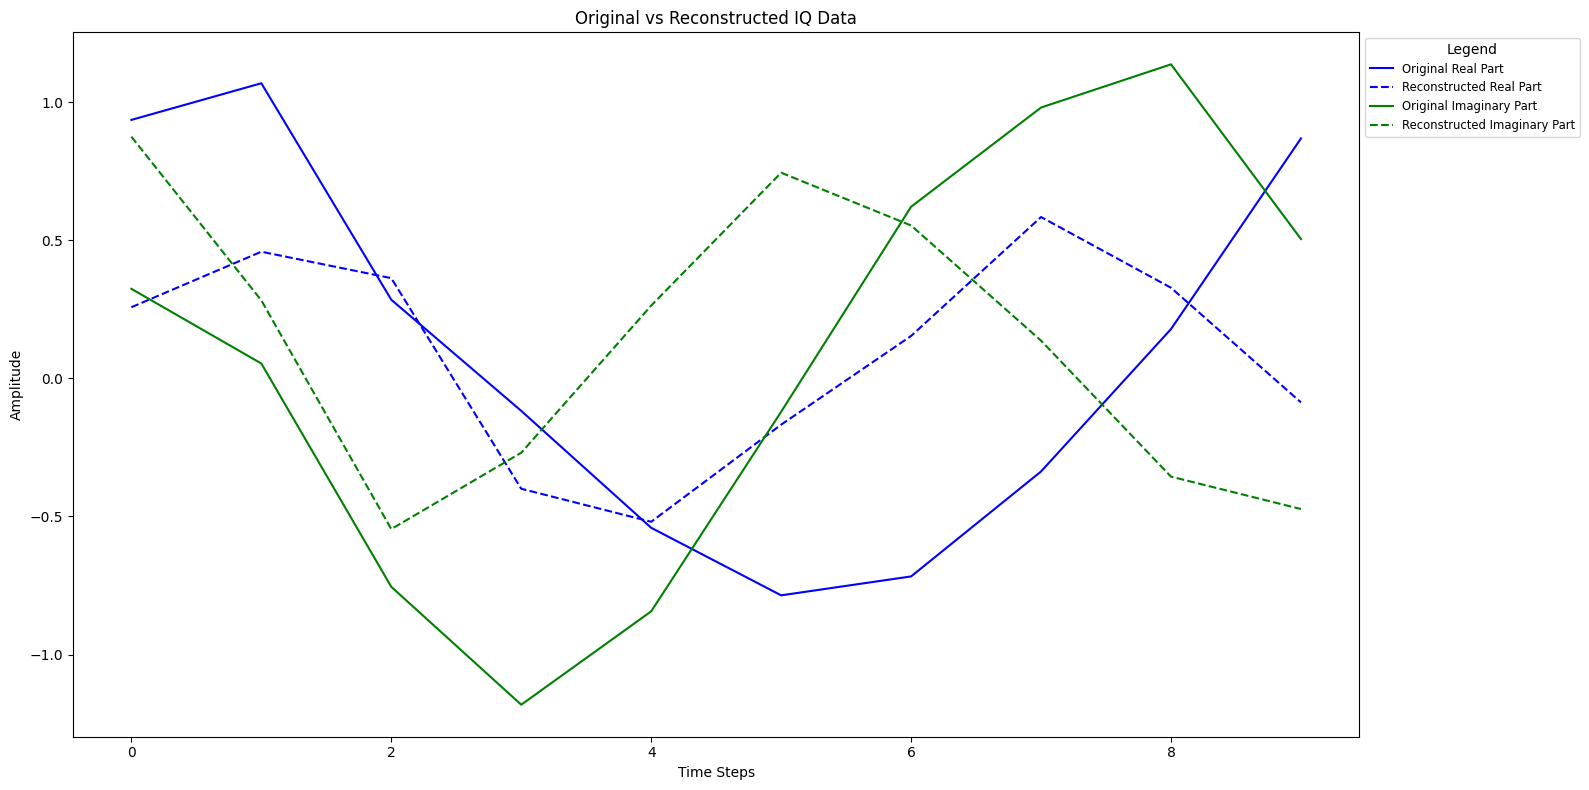

In [14]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()